In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import json
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
         
def load_data(path):
    
    for folder in os.listdir(path):    # Create the folder path
        folder_path = os.path.join(path, folder)
        
        if(os.path.isdir(folder_path)):    # Checking for the folder's existence
            for img_name in os.listdir(folder_path):
                
                img_path = os.path.join(folder_path, img_name)
                key_name = folder + '/' + img_name
                label = train_data[key_name]
                
                if(samples[label] > 2000):
                    continue
                    
                samples[label] += 1
                img = Image.open(img_path).resize(imgpx)
                img = tf.convert_to_tensor(img)
                data.append((img, onehot[label]))
                
                if(not np.mod(len(data), 100)): 
                    print(f"Total images loaded : {len(data)}, Label count : {samples}", end = '\r')

In [3]:
training_data_file = '/kaggle/input/tig-aluminium-5083/al5083/train/train.json'

with open(training_data_file, 'r') as tdf:
    train_data = json.load(tdf)

In [4]:
labels = ["good weld", "burn through", "contamination", "lack of fusion", "misalignment", "lack of penetration"]
labels = {i : labels[i] for i in range(6)}
onehot = tf.keras.utils.to_categorical([int(key) for key in labels.keys()], num_classes=6)
samples = [0, 0, 0, 0, 0, 0]

for label in train_data:
    samples[train_data[label]] += 1
    
samples

[8758, 1783, 6325, 4028, 2953, 2819]

In [5]:
data = []
imgpx = (256, 256)
samples = [0, 0, 0, 0, 0, 0]
load_data('/kaggle/input/tig-aluminium-5083/al5083/train')

In [6]:
random.shuffle(data)
X = []
y = []

for datum in data:
    X.append(datum[0])
    y.append(datum[1])
    
index = random.randint(0, len(data))
X[index], y[index]

(<tf.Tensor: shape=(256, 256), dtype=uint8, numpy=
 array([[19, 19, 18, ...,  6,  6,  6],
        [18, 18, 18, ...,  6,  6,  6],
        [18, 18, 18, ...,  6,  6,  5],
        ...,
        [16, 15, 15, ..., 33, 32, 32],
        [15, 15, 15, ..., 32, 32, 32],
        [14, 14, 15, ..., 31, 31, 32]], dtype=uint8)>,
 array([0., 0., 1., 0., 0., 0.], dtype=float32))

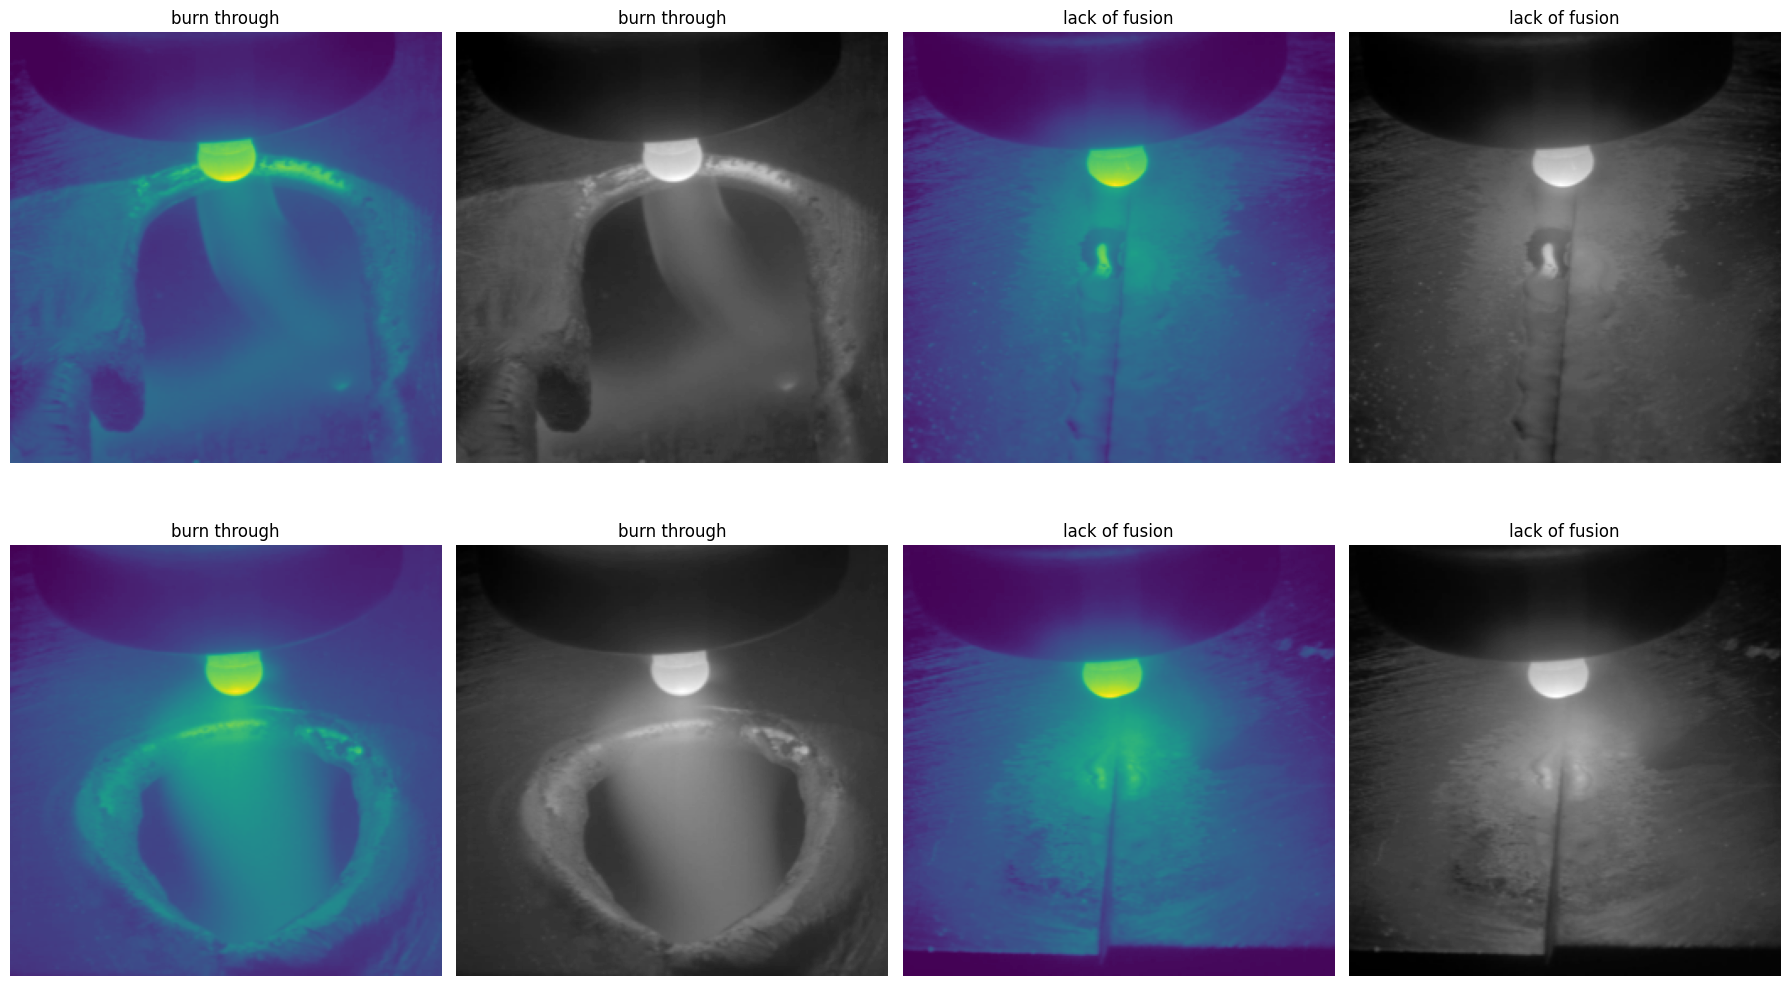

In [7]:
figure = plt.figure(figsize=(18, 11))
cols, rows = 4, 2
for i in range(1, cols*rows + 1, 2):
        
    img_idx = random.randint(0, len(X) - 1)
    
    figure.add_subplot(rows, cols, i)
    label_idx = np.argmax(y[img_idx]).item()  # Convert tensor to plain integer
#     print(f"Label: {labels[label_idx]}")
    
    plt.title(labels[label_idx])
    plt.axis("off")
    plt.imshow(X[img_idx])
    
    
    figure.add_subplot(rows, cols, i+1)
    label_idx = np.argmax(y[img_idx]).item()  # Convert tensor to plain integer
#     print(f"Label: {labels[label_idx]}")
    
    plt.title(labels[label_idx])
    plt.axis("off")
    plt.imshow(X[img_idx], cmap = 'gray')
    

# plt.suptitle('Weld Images', y=0.95)
plt.tight_layout()
plt.show()


In [8]:
data_size = len(X)
split = int(data_size*0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [9]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(TensorShape([9430, 256, 256]),
 TensorShape([9430, 6]),
 TensorShape([2358, 256, 256]),
 TensorShape([2358, 6]))

In [11]:
X_train = tf.reshape(X_train, shape=(len(X_train), 256, 256, 1))
X_test = tf.reshape(X_test, shape=(len(X_test), 256, 256, 1))

X_train.shape, y_train.shape

(TensorShape([9430, 256, 256, 1]), TensorShape([9430, 6]))

In [12]:
class Model(tf.keras.Model):

    def __init__(self, l2_reg = 0.01):    # L2 regularization - Preventing overfitting
        super().__init__()
        self.conv1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(imgpx[0], imgpx[1], 1), kernel_regularizer=regularizers.l2(l2_reg))
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout1 = layers.Dropout(0.2)
        
        self.conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))
        self.pool4 = layers.MaxPooling2D((2, 2))
        self.dropout3 = layers.Dropout(0.2)
        
        self.conv5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_reg))
        self.pool5 = layers.MaxPooling2D((2, 2))
        
        self.flatten = layers.Flatten()

        self.dense1 = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))
        self.dense2 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))
        self.dense3 = layers.Dense(len(labels), activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.dropout3(x)
        
        x = self.conv5(x)
        x = self.pool5(x)

        x = self.flatten(x)

        x = self.dense1(x)
        x = self.dense2(x)
        output = self.dense3(x)

        return output


In [13]:
model = Model()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),    # From paper, learning rate -3, -4, -5 can work
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [14]:
print(f"Train dataset Size : {len(X_train)}\nTest Dataset size : {len(X_test)}")

Train dataset Size : 9430
Test Dataset size : 2358


In [15]:
callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/model',
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [16]:
model.fit(x=X_train, y=y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[callback1])

Epoch 1/30


2024-08-09 15:21:42.801596: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


295/295 [==============================] - ETA: 0s - loss: 134.9099 - accuracy: 0.6971
Epoch 1: val_accuracy improved from -inf to 0.84478, saving model to /model
295/295 [==============================] - 112s 358ms/step - loss: 134.9099 - accuracy: 0.6971 - val_loss: 16.1502 - val_accuracy: 0.8448
Epoch 2/30
295/295 [==============================] - ETA: 0s - loss: 13.5721 - accuracy: 0.9077
Epoch 2: val_accuracy improved from 0.84478 to 0.90373, saving model to /model
295/295 [==============================] - 103s 350ms/step - loss: 13.5721 - accuracy: 0.9077 - val_loss: 11.5388 - val_accuracy: 0.9037
Epoch 3/30
295/295 [==============================] - ETA: 0s - loss: 9.6786 - accuracy: 0.9473
Epoch 3: val_accuracy did not improve from 0.90373
295/295 [==============================] - 103s 348ms/step - loss: 9.6786 - accuracy: 0.9473 - val_loss: 11.5527 - val_accuracy: 0.8147
Epoch 4/30
295/295 [==============================] - ETA: 0s - loss: 10.9516 - accuracy: 0.9003
Epoch 

In [17]:
model.load_weights('/model')

In [18]:
predictions = model.predict(X_test)

74/74 [==============================] - 3s 35ms/step


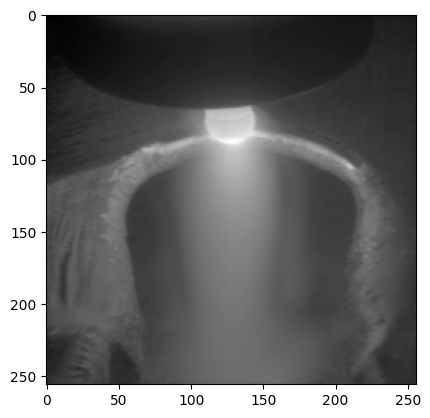

Prediction : burn through
Original : burn through


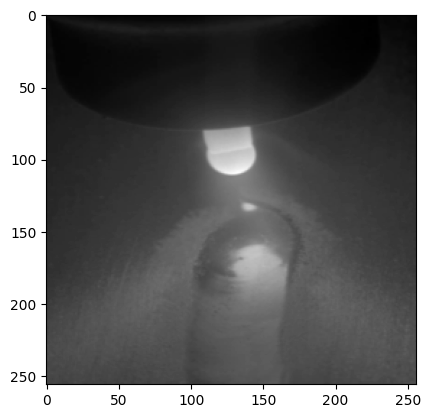

Prediction : lack of penetration
Original : lack of penetration


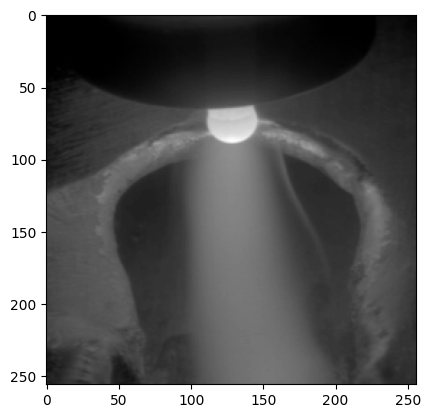

Prediction : burn through
Original : burn through


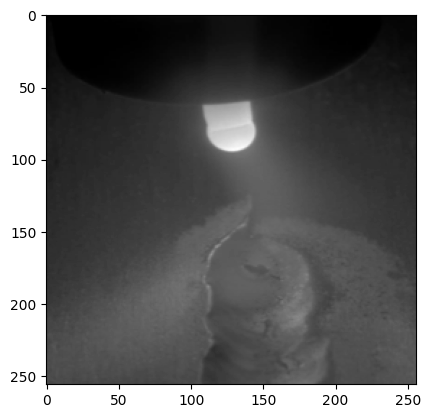

Prediction : contamination
Original : contamination


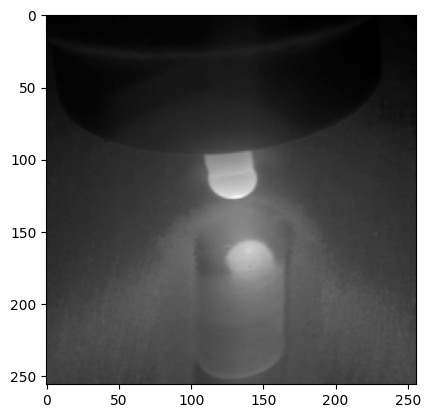

Prediction : lack of penetration
Original : lack of penetration


In [19]:
for _ in range(5):
    img = random.randint(0, len(X_test))
    plt.imshow(X_test[img].numpy(), cmap='gray')
    plt.show()
    print(f"Prediction : {labels[np.argmax(predictions[img])]}")
    print(f"Original : {labels[np.argmax(y_test[img])]}")

In [20]:
train_metric = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss : {train_metric[0]} , Training Accuracy : {train_metric[1]}")

Training Loss : 2.571864604949951 , Training Accuracy : 0.992682933807373


In [21]:
test_metric = model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss : {test_metric[0]} , Testing Accuracy : {test_metric[1]}")

Testing Loss : 2.5713396072387695 , Testing Accuracy : 0.9936386942863464
